# Mapping Transport Frequency in Mumbai

Mumbia Metro: http://www.gtfs-data-exchange.com/agency/mumbai-metro/

Bus routes in greater Mumbai operated by BEST (Brihanmumbai Electric Supply & Transport Undertaking) from February 2015 valid up to July 2015: http://www.gtfs-data-exchange.com/agency/best/

Mumbia vector data: https://www.lib.msu.edu/branches/map/findingaids/Mumbai-vector/

Google forum - get mumbai local train? https://groups.google.com/forum/#!topic/datameet/B5HoyDcLcrw

Transport 4 Mumbai timetable! http://transportformumbai.com/mumbai_local_train_complete_time_table.php

In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import math
from IPython.display import Image

In [2]:
def read_gtfs(pathToGTFS):
    stop_times = pd.read_csv(pathToGTFS + "stop_times.txt")
    stops = pd.read_csv(pathToGTFS + "stops.txt")
    trips = pd.read_csv(pathToGTFS + "trips.txt")
    calendar = pd.read_csv(pathToGTFS + "calendar.txt")   
    routes = pd.read_csv(pathToGTFS + "routes.txt")   
    
    return stop_times, stops, trips, calendar, routes

def join_gtfs(stop_times, stops, trips, calendar, routes):
    
    stop_times = stop_times[['trip_id', 'arrival_time', 'departure_time', 'stop_id']]
    
    # Left join `stop_times` with `stops` to get `stop_lat` and `stop_lon`.
    stop_times = pd.merge(stop_times, stops[['stop_id', 'stop_lat', 'stop_lon']], how="left")

    # Left join `stop_times` with `trips` to get `route_id` and `service_id`.
    stop_times = pd.merge(stop_times, trips[['trip_id', 'route_id', 'service_id']], how="left")

    # Left join `stop_times` with routes to get `route_type`
    stop_times = pd.merge(stop_times, routes[['route_id', 'route_type']], how="left")
    
    # Left join `stop_times` with `calendar` to get `monday`, `tuesday`, `wednesday`, `thursday`, `friday`, `saturday`, `sunday`.
    stop_times = pd.merge(stop_times, calendar[['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', \
                                   'friday', 'saturday', 'sunday']],
             how="left", on="service_id")
    
    stop_times = stop_times.sort_values(by=['trip_id', 'arrival_time'])
    return stop_times

def clean_times(df):
    
    # Clean departure times
    departure_hour = df['departure_time'].apply(lambda x: int(x.split(":")[0]))
    departure_minute = df['departure_time'].apply(lambda x: x.split(":")[1])
    departure_second = df['departure_time'].apply(lambda x: x.split(":")[2])
    
    departure_hour = np.where(24 <= departure_hour, departure_hour - 24, departure_hour)
    departure_hour = np.where(24 <= departure_hour, departure_hour - 24, departure_hour)
    
    df['departure_hour'] = departure_hour
    df['departure_minute'] = departure_minute
    df['departure_second'] = departure_second
    df['departure_time_clean'] = df['departure_hour'].apply(lambda x: str(x)) + ":" + df['departure_minute'] + ":" + df['departure_second']
    
    del df['departure_hour']
    del df['departure_minute']
    del df['departure_second']
    
    # Clean arrival times
    arrival_hour = df['arrival_time'].apply(lambda x: int(x.split(":")[0]))
    arrival_minute = df['arrival_time'].apply(lambda x: x.split(":")[1])
    arrival_second = df['arrival_time'].apply(lambda x: x.split(":")[2])
    
    arrival_hour = np.where(24 <= arrival_hour, arrival_hour - 24, arrival_hour)
    arrival_hour = np.where(24 <= arrival_hour, arrival_hour - 24, arrival_hour)
    
    df['arrival_hour'] = arrival_hour
    df['arrival_minute'] = arrival_minute
    df['arrival_second'] = arrival_second
    df['arrival_time_clean'] = df['arrival_hour'].apply(lambda x: str(x)) + ":" + df['arrival_minute'] + ":" + df['arrival_second']
    
    del df['arrival_hour']
    del df['arrival_minute']
    del df['arrival_second']

    return df

def generate_arbitary_dates(startdate = '2017-06-05', number_of_days=10):
    arbitrary_dates = []
    start = dt.datetime.strptime(startdate, "%Y-%m-%d").date()
    for i in range(number_of_days):
        arbitrary_dates.append(start.strftime("%Y-%m-%d"))
        start += dt.timedelta(1)
    return arbitrary_dates

def add_dates(df, arbitrary_dates):
    
    # Grab monday and tuesday dates
    monday_date = arbitrary_dates[0]
    tuesday_date = arbitrary_dates[1]
    wednesday_date = arbitrary_dates[2]
    
    # Departure date
    departure_hour = df['departure_time'].apply(lambda x: int(x.split(":")[0]))
    same_day_or_next_day_departure = np.where(24 <= departure_hour, "next_day", "same_day")
    departure_date = np.where(same_day_or_next_day_departure == "same_day", monday_date, tuesday_date)
    df['departure_date'] = departure_date
    
    # Arrival date
    arrival_hour = df['arrival_time'].apply(lambda x: int(x.split(":")[0]))
    same_day_or_next_day_arrival = np.where(24 <= arrival_hour, "next_day", "same_day")
    arrival_date = np.where(same_day_or_next_day_arrival == "same_day", monday_date, tuesday_date)
    df['arrival_date'] = arrival_date
    
    # Make datetimes
    df['departure_datetime'] = df['departure_date'] + ' ' + df['departure_time_clean']
    df['arrival_datetime'] = df['arrival_date'] + ' ' + df['arrival_time_clean']
    
    return df

def process_data(df):
    df = df[['trip_id', 'stop_lat', 'stop_lon', 'route_id', 'route_type', 'departure_datetime']].copy()
    
    # If trip id changes; 1. Else; 0.
    df['end_of_trip'] = df['trip_id'].ne(df['trip_id'].shift().bfill()).astype(int).shift(-1).ffill()
    df['stop_lat_shift'] = df['stop_lat'].shift(-1).ffill()
    df['stop_lon_shift'] = df['stop_lon'].shift(-1).ffill()
    df['datetime_shift'] = df['departure_datetime'].shift(-1).ffill()

    df['end_lat'] = np.where(df['end_of_trip'] == 1, df['stop_lat'], df['stop_lat_shift'])
    df['end_lon'] = np.where(df['end_of_trip'] == 1, df['stop_lon'], df['stop_lon_shift'])
    df['end_datetime'] = np.where(df['end_of_trip'] == 1, df['departure_datetime'], df['datetime_shift'])

    df = df[['trip_id', 'route_id', 'route_type', 'departure_datetime', 'stop_lat', 'stop_lon', 'end_datetime', 'end_lat', 'end_lon']]
    df.columns = ['trip_id', 'route_id', 'route_type', 'start_time', 'start_lat', 'start_lon', 'end_time', 'end_lat', 'end_lon']
    
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df['duration'] = ((df['end_time'] - df['start_time']) / np.timedelta64(1, 's')).astype(int)
    
    df = df.sort_values(by=['start_time'])
    
    df = df[df.duration != 0].reset_index(drop=True)

    return df

# Calculate bearing
# See: https://gis.stackexchange.com/questions/29239/calculate-bearing-between-two-decimal-gps-coordinates/48911
def calc_bearing_between_points(startLat, startLong, endLat, endLong):

    startLat = math.radians(startLat)
    startLong = math.radians(startLong)
    endLat = math.radians(endLat)
    endLong = math.radians(endLong)
    dLong = endLong - startLong
    dPhi = math.log(math.tan(endLat/2.0+math.pi/4.0)/math.tan(startLat/2.0+math.pi/4.0))
    if abs(dLong) > math.pi:
        if dLong > 0.0:
            dLong = -(2.0 * math.pi - dLong)
        else:
            dLong = (2.0 * math.pi + dLong)
    bearing = (math.degrees(math.atan2(dLong, dPhi)) + 360.0) % 360.0;
    return bearing

### Mumbai Metro

In [4]:
operator_name = "metro"
directory_name = "mumbai-metro_20151216_1419"
stop_times, stops, trips, calendar, routes = read_gtfs("../gtfs/gtfs/" + directory_name + "/")
df = join_gtfs(stop_times, stops, trips, calendar, routes)
df = clean_times(df)
arbitrary_dates = generate_arbitary_dates()
monday = df[df['monday'] == 1].reset_index(drop=True)
monday = add_dates(monday, arbitrary_dates)
metro_monday = process_data(monday)
metro_monday['operator'] = operator_name

In [5]:
metro_monday.head()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator
0,1871711,91190,1,2017-06-05 05:31:00,19.085110,72.907537,2017-06-05 05:34:00,19.092057,72.903476,180,metro
1,1871711,91190,1,2017-06-05 05:34:00,19.092057,72.903476,2017-06-05 05:36:00,19.096537,72.895941,120,metro
2,1872059,91191,1,2017-06-05 05:35:00,19.130451,72.821912,2017-06-05 05:37:00,19.128434,72.830023,120,metro
3,1871711,91190,1,2017-06-05 05:36:00,19.096537,72.895941,2017-06-05 05:38:00,19.103659,72.888688,120,metro
4,1872059,91191,1,2017-06-05 05:37:00,19.128434,72.830023,2017-06-05 05:39:00,19.126676,72.839802,120,metro


### Bus Routes

In [6]:
operator_name = "bus"
directory_name = "best_20150714_1102"
stop_times, stops, trips, calendar, routes = read_gtfs("../gtfs/gtfs/" + directory_name + "/")
df = join_gtfs(stop_times, stops, trips, calendar, routes)

In [7]:
df['arrival_time'] = df['arrival_time'].apply(str)
df = df[df['arrival_time'] != 'nan']

In [8]:
df = clean_times(df)

In [9]:
arbitrary_dates = generate_arbitary_dates()
monday = df[df['monday'] == 1].reset_index(drop=True)
monday = add_dates(monday, arbitrary_dates)
bus_monday = process_data(monday)
bus_monday['operator'] = operator_name

In [10]:
bus_monday.head()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator
0,5011_MS_1383_h1_1_1,5011,3,2017-06-05 00:12:00,19.157342,72.998249,2017-06-05 01:30:00,19.054071,72.889344,4680,bus
1,0661_FW_1817_double_1_0,661,3,2017-06-05 00:15:00,18.916136,72.827139,2017-06-05 01:09:36,19.051701,72.859300,3276,bus
2,0661_FW_1818_double_1_1,661,3,2017-06-05 00:25:00,19.051701,72.859300,2017-06-05 01:19:36,18.916136,72.827139,3276,bus
3,0661_FW_1819_double_1_1,661,3,2017-06-05 00:25:00,19.051701,72.859300,2017-06-05 01:19:36,18.916136,72.827139,3276,bus
4,0661_FW_1817_double_1_1,661,3,2017-06-05 00:25:00,19.051701,72.859300,2017-06-05 01:19:36,18.916136,72.827139,3276,bus


### Combine Metro and Bus

In [11]:
output = pd.concat([metro_monday, bus_monday])

In [12]:
output = output.sort_values(by='start_time')

In [13]:
output = output[output['duration'] > 0]

output['bearing'] = output.apply(lambda row: calc_bearing_between_points(row['start_lat'], row['start_lon'], row['end_lat'], row['end_lon']), axis=1)

In [14]:
output.to_csv("../gtfs/gtfs/mumbai_bus_metro.csv")

In [532]:
output

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
0,5011_MS_1383_h1_1_1,5011,3,2017-06-05 00:12:00,19.157342,72.998249,2017-06-05 01:30:00,19.054071,72.889344,4680,bus,224.898885
1,0661_FW_1817_double_1_0,661,3,2017-06-05 00:15:00,18.916136,72.827139,2017-06-05 01:09:36,19.051701,72.859300,3276,bus,12.643930
2,0661_FW_1818_double_1_1,661,3,2017-06-05 00:25:00,19.051701,72.859300,2017-06-05 01:19:36,18.916136,72.827139,3276,bus,192.643930
3,0661_FW_1819_double_1_1,661,3,2017-06-05 00:25:00,19.051701,72.859300,2017-06-05 01:19:36,18.916136,72.827139,3276,bus,192.643930
4,0661_FW_1817_double_1_1,661,3,2017-06-05 00:25:00,19.051701,72.859300,2017-06-05 01:19:36,18.916136,72.827139,3276,bus,192.643930
5,0661_FW_1818_double_1_0,661,3,2017-06-05 00:30:00,18.916136,72.827139,2017-06-05 01:24:36,19.051701,72.859300,3276,bus,12.643930
6,5011_MS_1383_h1_2_1,5011,3,2017-06-05 00:32:00,19.157342,72.998249,2017-06-05 01:50:00,19.054071,72.889344,4680,bus,224.898885
7,0661_FW_1817_double_2_0,661,3,2017-06-05 00:42:00,18.916136,72.827139,2017-06-05 01:36:36,19.051701,72.859300,3276,bus,12.643930
8,5011_MS_1383_h1_3_1,5011,3,2017-06-05 00:52:00,19.157342,72.998249,2017-06-05 02:10:00,19.054071,72.889344,4680,bus,224.898885
9,0661_FW_1818_double_2_0,661,3,2017-06-05 00:54:00,18.916136,72.827139,2017-06-05 01:48:36,19.051701,72.859300,3276,bus,12.643930


# Scrape time tables from PDF

Use Tabula to scrape timetables from http://transportformumbai.com/mumbai_local_train_complete_time_table.php

Scraped data here: https://docs.google.com/spreadsheets/d/1VbpLl_BCdzDxbjR2dF_XOpcciA5t7NB5q-2r0QI_5Jc/edit#gid=0

from IPython.display import Image

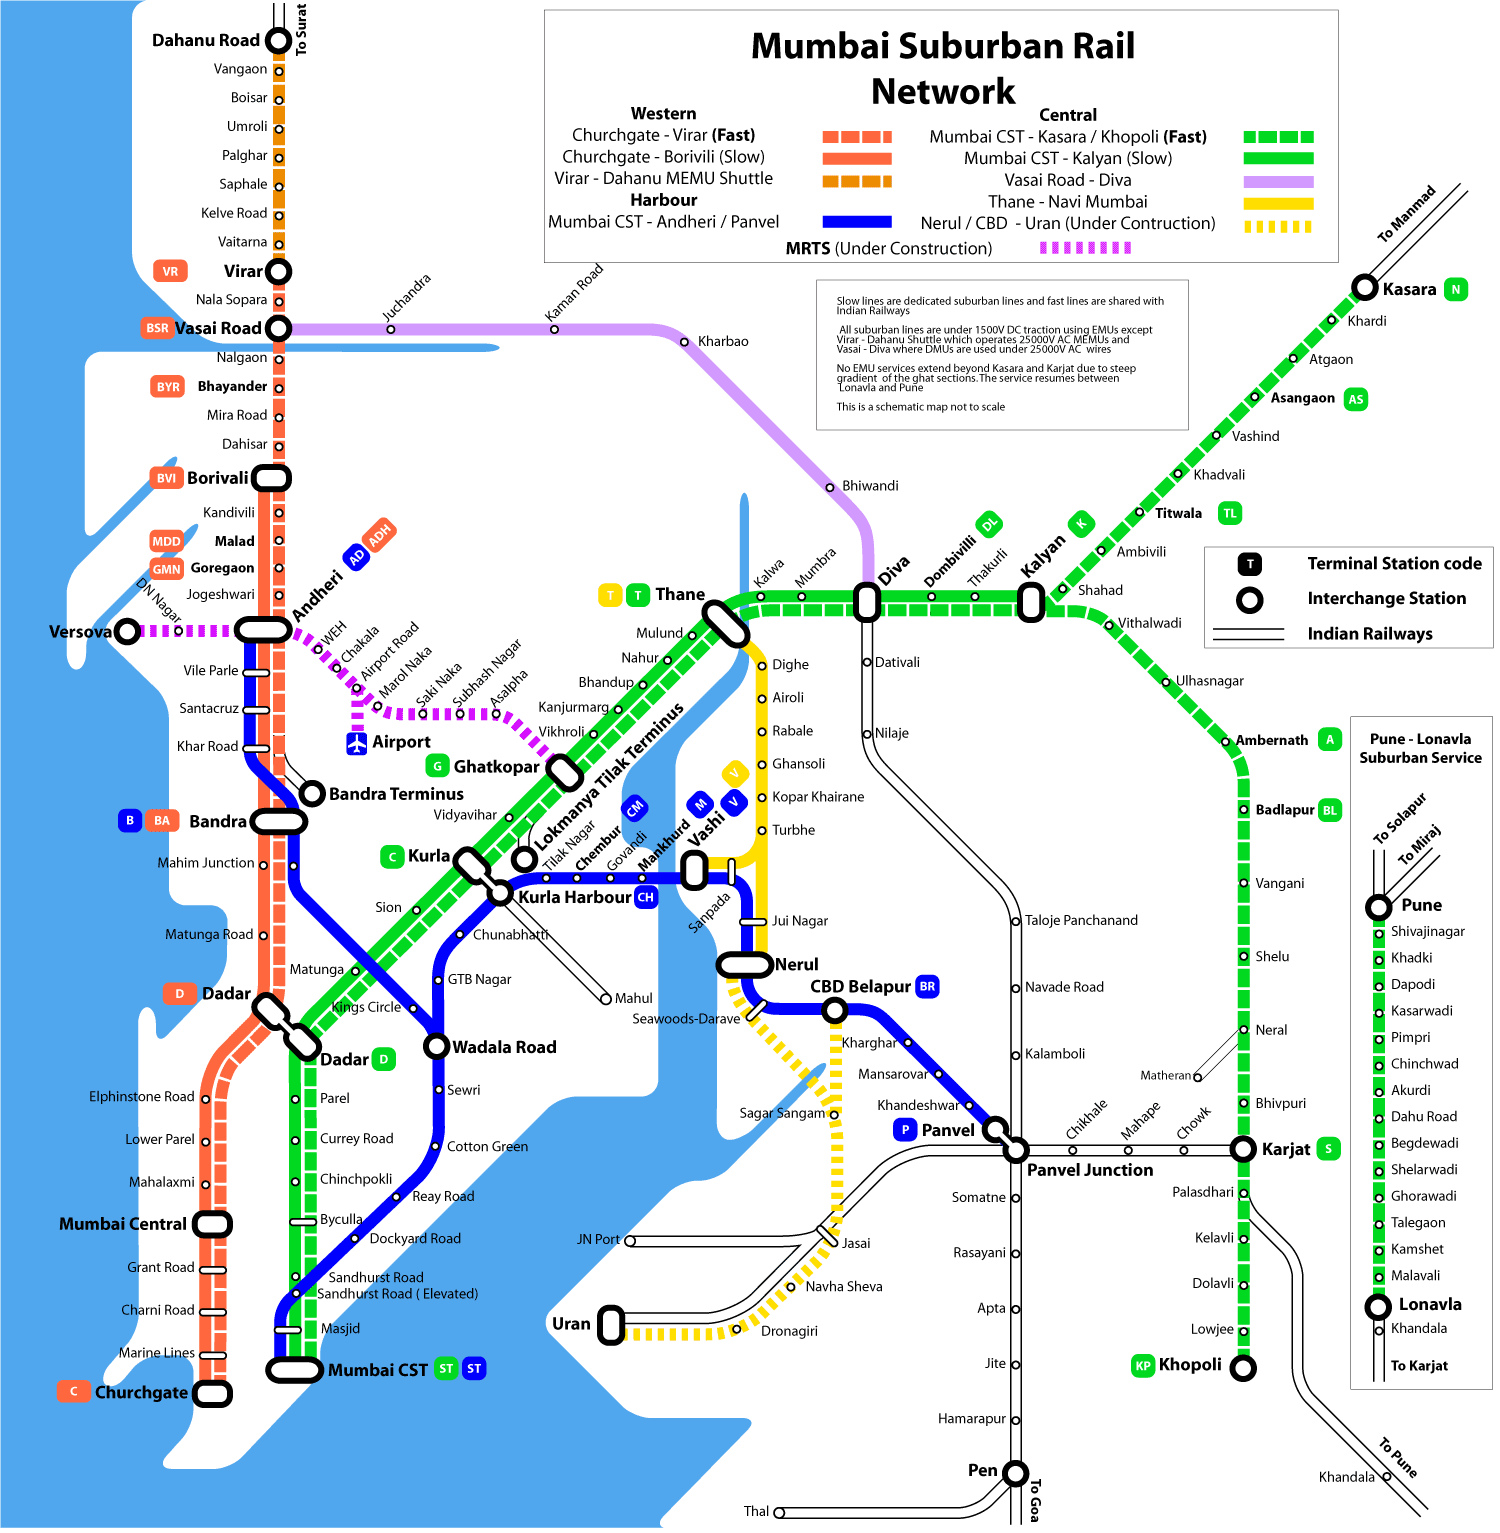

In [19]:
Image("http://transportformumbai.com/images/Mumbai_suburban_rail_map.jpeg")

# Geocode Train Station Names

In [20]:
import requests

In [22]:
# Stations tab
# https://docs.google.com/spreadsheets/d/1VbpLl_BCdzDxbjR2dF_XOpcciA5t7NB5q-2r0QI_5Jc/edit#gid=583825587
stations = pd.read_clipboard(sep='\t')
stations = set(stations['Station'])

In [23]:
stations

{'Andheri',
 'Bandra',
 'Belapur',
 'Bhayandar',
 'Borivali',
 'Bvelapur CBD',
 'Byculla',
 'Charni Road',
 'Chembur',
 'Chinchpokli',
 'Chunabhatti',
 'Churchgate',
 'Cotton Green',
 'Currey Road',
 'Dadar',
 'Dahisar',
 'Darave Belapur CBD',
 'Dockyard Road',
 'Elphinstone Road',
 'GTB Nagar',
 'Goregaon',
 'Govandi',
 'Grant Road',
 'Jogeshwari',
 'Jui Nagar',
 'Kandivali',
 'Khandeshwar',
 'Khar Road',
 'Kharghar',
 'Kings Circle',
 'Kurla',
 'Lower Parel',
 'Mahalakshmi',
 'Mahim',
 'Malad',
 'Mankhurd',
 'Mansarova',
 'Mansarovar',
 'Marine Lines',
 'Masjid',
 'Matunga',
 'Mira Road',
 'Mumbai CST',
 'Mumbai Central',
 'Naigaon',
 'Nalla Sopara',
 'Nerul',
 'Panvel',
 'Parel',
 'Reay Road',
 'Sandhurst Road',
 'Sanpada',
 'Santacruz',
 'Seawood',
 'Seawood Dara',
 'Sewri',
 'Sion',
 'Tilak Nagar',
 'Vadala Road',
 'Vasai Road',
 'Vashi',
 'Vile Parle',
 'Virar',
 'ambernath',
 'ambivli',
 'asangaon',
 'atgaon',
 'badlapur',
 'bhandup',
 'bhivpuri',
 'diva',
 'dolavli',
 'dombivli

In [36]:
def geocode_train_stations(stations):
    results = {}
    geocode_api_template = "https://maps.googleapis.com/maps/api/geocode/json?address={}"
    for station in stations:
        geocode_api_string = geocode_api_template.format(station + 'railway station Mumbai India')
        try:
            response = requests.get(geocode_api_string)
            data = response.json()
            results[station] = data
        except:
            print station, "failed to geocode."
    return results

In [37]:
stations_geocoded = geocode_train_stations(stations)

In [78]:
stations_geocoded['vidyavihar']['results'][0]['geometry']['location']

{u'lat': 19.0802204, u'lng': 72.89834479999999}

## Wrangling Train Timetable data

The timetables come in different formats depending on which line :/

So we need to write separate functions to parse data.

In [187]:
import csv
from collections import defaultdict

Sometimes they look like this:

In [39]:
df1 = pd.read_clipboard()

In [40]:
df1

,,,line,source,destination,speed,Mumbai,CST,Masjid
Harbour,Line,Mumbai,CST,Chembur,S,8:33,AM,8:36,AM


Other times they look like this:

In [46]:
df2 = pd.read_clipboard()
df2

,line,Train,Train no,Train no.1,Train no.2
0,Western Line,source,Churchgate,Churchgate,Churchgate
1,Western Line,destination,Bhayandar,Bhayandar,Bhayandar
2,Western Line,speed,S,S,S
3,Western Line,Churchgate,12:30 AM,10:54 AM,6:51 PM


In [506]:
def parseTrainTrips(data):
    
    output = pd.DataFrame()
    
    lines = []
    sources = []
    destinations = []
    speeds = []
    stop_times = []
    stop_stations= []
    counts = []
    
    count = 0
    with open(data, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        stations = None
        
        for row in reader:
                
            row = [i for i in row if i != ""] # drop blank cells
            
            # It it's a blank row
            if len(row) == 0:
                pass
            
            # If it's a header row
            elif row[0] == 'line':
                stations = row[4:]
                

            # If it's a data row
            else:
                line = row[0]
                source = row[1]
                destination = row[2]
                speed = row[3]
                times = row[4:]
                for t in range(len(times)):
                    counts.append(count)
                    lines.append(line)
                    sources.append(source)
                    destinations.append(destination)
                    speeds.append(speed)
                    stop_times.append(times[t])
                for s in stations:
                    stop_stations.append(s)
                count += 1
                                            
        output['trip_id'] = counts
        output['line'] = lines
        output['source'] = sources
        output['destination'] = destinations
        output['speed'] = speeds
        output['stations'] = stop_stations
        output['time'] = stop_times
        return output
                
trains = parseTrainTrips("../gtfs/mumbai_train.csv")

In [507]:
trains['start_time'] = trains['time']
trains['end_time'] = trains['start_time'].shift(-1).ffill()
clean_endtimes = []
for i in range(len(trains.index)):
    this_tripid = trains.loc[i]['trip_id']
    if i == max(trains.index):
        last_endtime = trains.loc[i-1]['end_time']
        clean_endtimes.append(last_endtime)
    else:
        next_tripid = trains.loc[i+1]['trip_id']
        if this_tripid == next_tripid:
            last_endtime = trains.loc[i]['end_time']
            clean_endtimes.append(last_endtime)
        else:
            last_endtime = trains.loc[i-1]['end_time']
            clean_endtimes.append(last_endtime)

In [508]:
trains['end_time'] = clean_endtimes

In [510]:
del trains['time']

In [511]:
del trains['speed']

In [512]:
trains.head(20)

,trip_id,line,source,destination,stations,start_time,end_time
0,0,Harbour Line,Mumbai CST,Chembur,Mumbai CST,8:33 AM,8:36 AM
1,0,Harbour Line,Mumbai CST,Chembur,Masjid,8:36 AM,8:39 AM
2,0,Harbour Line,Mumbai CST,Chembur,Sandhurst Road,8:39 AM,8:41 AM
3,0,Harbour Line,Mumbai CST,Chembur,Dockyard Road,8:41 AM,8:43 AM
4,0,Harbour Line,Mumbai CST,Chembur,Reay Road,8:43 AM,8:45 AM
5,0,Harbour Line,Mumbai CST,Chembur,Cotton Green,8:45 AM,8:48 AM
6,0,Harbour Line,Mumbai CST,Chembur,Sewri,8:48 AM,8:51 AM
7,0,Harbour Line,Mumbai CST,Chembur,Vadala Road,8:51 AM,8:55 AM
8,0,Harbour Line,Mumbai CST,Chembur,GTB Nagar,8:55 AM,8:58 AM
9,0,Harbour Line,Mumbai CST,Chembur,Chunabhatti,8:58 AM,9:01 AM


In [513]:
lats = []
lons = []

for i in trains.index:
    
    station = trains.loc[i]
    try:
        location = stations_geocoded[station.loc['stations']]['results'][0]['geometry']['location']
        lon = location['lng']
        lat = location['lat']
    except:
        lon = 0
        lat = 0
    lons.append(lon)
    lats.append(lat)
    

In [514]:
trains['start_lat'] = lats
trains['start_lon'] = lons

In [515]:
trains.head()

,trip_id,line,source,destination,stations,start_time,end_time,start_lat,start_lon
0,0,Harbour Line,Mumbai CST,Chembur,Mumbai CST,8:33 AM,8:36 AM,18.939821,72.835468
1,0,Harbour Line,Mumbai CST,Chembur,Masjid,8:36 AM,8:39 AM,18.951993,72.838271
2,0,Harbour Line,Mumbai CST,Chembur,Sandhurst Road,8:39 AM,8:41 AM,18.960941,72.839386
3,0,Harbour Line,Mumbai CST,Chembur,Dockyard Road,8:41 AM,8:43 AM,18.968376,72.843476
4,0,Harbour Line,Mumbai CST,Chembur,Reay Road,8:43 AM,8:45 AM,18.977184,72.844214


In [516]:
trains['end_lat'] = trains['start_lat'].shift(-1).ffill()
trains['end_lon'] = trains['start_lon'].shift(-1).ffill()
clean_endlats = []
clean_endlons = []

for i in range(len(trains.index)):
    this_tripid = trains.loc[i]['trip_id']
    if i == max(trains.index):
        last_endlat = trains.loc[i-1]['end_lat']
        last_endlon = trains.loc[i-1]['end_lon']
        clean_endlats.append(last_endlat)
        clean_endlons.append(last_endlon)
    else:
        next_tripid = trains.loc[i+1]['trip_id']
        if this_tripid == next_tripid:
            last_endlat = trains.loc[i]['end_lat']
            last_endlon = trains.loc[i]['end_lon']
            clean_endlats.append(last_endlat)
            clean_endlons.append(last_endlon)
        else:
            last_endlat = trains.loc[i-1]['end_lat']
            last_endlon = trains.loc[i-1]['end_lon']
            clean_endlats.append(last_endlat)
            clean_endlons.append(last_endlon)

In [517]:
trains['clean_end_lat'] = clean_endlats
trains['clean_end_lon'] = clean_endlons

In [518]:
trains['end_lat'] = trains['clean_end_lat']
trains['end_lon'] = trains['clean_end_lon']

del trains['clean_end_lat']
del trains['clean_end_lon']

In [519]:
trains[trains['stations'] == 'palasdari']

,trip_id,line,source,destination,stations,start_time,end_time,start_lat,start_lon,end_lat,end_lon
14902,698,Central Line,Mumbai CST,Khopoli,palasdari,9:47 AM,9:54 AM,0.0,0.0,18.939821,72.835468
14942,699,Central Line,Mumbai CST,Khopoli,palasdari,2:26 PM,2:33 PM,0.0,0.0,18.939821,72.835468
14982,700,Central Line,Mumbai CST,Khopoli,palasdari,5:25 PM,5:32 PM,0.0,0.0,18.939821,72.835468
15022,701,Central Line,Mumbai CST,Khopoli,palasdari,7:40 PM,7:47 PM,0.0,0.0,18.939821,72.835468
15062,702,Central Line,Mumbai CST,Khopoli,palasdari,10:44 PM,10:51 PM,0.0,0.0,18.939821,72.835468
15102,703,Central Line,Mumbai CST,Khopoli,palasdari,12:02 AM,12:09 AM,0.0,0.0,18.939821,72.835468


In [520]:
trains[trains['end_lat'] == 0]

,trip_id,line,source,destination,stations,start_time,end_time,start_lat,start_lon,end_lat,end_lon
14901,698,Central Line,Mumbai CST,Khopoli,karjat,9:41 AM,9:47 AM,18.911529,73.320904,0.0,0.0
14941,699,Central Line,Mumbai CST,Khopoli,karjat,2:20 PM,2:26 PM,18.911529,73.320904,0.0,0.0
14981,700,Central Line,Mumbai CST,Khopoli,karjat,5:19 PM,5:25 PM,18.911529,73.320904,0.0,0.0
15021,701,Central Line,Mumbai CST,Khopoli,karjat,7:34 PM,7:40 PM,18.911529,73.320904,0.0,0.0
15061,702,Central Line,Mumbai CST,Khopoli,karjat,10:38 PM,10:44 PM,18.911529,73.320904,0.0,0.0
15101,703,Central Line,Mumbai CST,Khopoli,karjat,11:56 PM,12:02 AM,18.911529,73.320904,0.0,0.0


In [521]:
# 18.88444444 73.32083333
clean_start_lats = []
clean_start_lons = []

for i in trains.index:
    
    if trains.loc[i]['stations'] == 'palasdari':
        clean_start_lats.append(18.88444444)
        clean_start_lons.append(73.32083333)
    else:
        clean_start_lats.append(trains.loc[i]['start_lat'])
        clean_start_lons.append(trains.loc[i]['start_lon'])

In [522]:
trains['start_lat'] = clean_start_lats
trains['start_lon'] = clean_start_lons

Should get clean start lat lons before doing the shift...

In [523]:
trains['end_lat'] = trains['start_lat'].shift(-1).ffill()
trains['end_lon'] = trains['start_lon'].shift(-1).ffill()
clean_endlats = []
clean_endlons = []

for i in range(len(trains.index)):
    this_tripid = trains.loc[i]['trip_id']
    if i == max(trains.index):
        last_endlat = trains.loc[i-1]['end_lat']
        last_endlon = trains.loc[i-1]['end_lon']
        clean_endlats.append(last_endlat)
        clean_endlons.append(last_endlon)
    else:
        next_tripid = trains.loc[i+1]['trip_id']
        if this_tripid == next_tripid:
            last_endlat = trains.loc[i]['end_lat']
            last_endlon = trains.loc[i]['end_lon']
            clean_endlats.append(last_endlat)
            clean_endlons.append(last_endlon)
        else:
            last_endlat = trains.loc[i-1]['end_lat']
            last_endlon = trains.loc[i-1]['end_lon']
            clean_endlats.append(last_endlat)
            clean_endlons.append(last_endlon)

In [524]:
arbitrary_date = "2017-06-05"

In [525]:
trains['start_datetime'] = pd.to_datetime(arbitrary_date + " " + trains['start_time'])
trains['end_datetime'] = pd.to_datetime(arbitrary_date + " " + trains['end_time'])

In [528]:
trains['duration'] = trains['end_datetime'] - trains['start_datetime']
trains['duration'] = trains['duration'].dt.seconds

In [535]:
trains['start_time'] = trains['start_datetime']
trains['end_time'] = trains['end_datetime']

del trains['start_datetime']
del trains['end_datetime']

In [536]:
trains

,trip_id,line,source,destination,stations,start_time,end_time,start_lat,start_lon,end_lat,end_lon,duration
0,0,Harbour Line,Mumbai CST,Chembur,Mumbai CST,2017-06-05 08:33:00,2017-06-05 08:36:00,18.939821,72.835468,18.951993,72.838271,180
1,0,Harbour Line,Mumbai CST,Chembur,Masjid,2017-06-05 08:36:00,2017-06-05 08:39:00,18.951993,72.838271,18.960941,72.839386,180
2,0,Harbour Line,Mumbai CST,Chembur,Sandhurst Road,2017-06-05 08:39:00,2017-06-05 08:41:00,18.960941,72.839386,18.968376,72.843476,120
3,0,Harbour Line,Mumbai CST,Chembur,Dockyard Road,2017-06-05 08:41:00,2017-06-05 08:43:00,18.968376,72.843476,18.977184,72.844214,120
4,0,Harbour Line,Mumbai CST,Chembur,Reay Road,2017-06-05 08:43:00,2017-06-05 08:45:00,18.977184,72.844214,18.986493,72.843286,120
5,0,Harbour Line,Mumbai CST,Chembur,Cotton Green,2017-06-05 08:45:00,2017-06-05 08:48:00,18.986493,72.843286,18.998875,72.854537,180
6,0,Harbour Line,Mumbai CST,Chembur,Sewri,2017-06-05 08:48:00,2017-06-05 08:51:00,18.998875,72.854537,19.016145,72.858969,180
7,0,Harbour Line,Mumbai CST,Chembur,Vadala Road,2017-06-05 08:51:00,2017-06-05 08:55:00,19.016145,72.858969,19.037984,72.864340,240
8,0,Harbour Line,Mumbai CST,Chembur,GTB Nagar,2017-06-05 08:55:00,2017-06-05 08:58:00,19.037984,72.864340,19.052393,72.869171,180
9,0,Harbour Line,Mumbai CST,Chembur,Chunabhatti,2017-06-05 08:58:00,2017-06-05 09:01:00,19.052393,72.869171,19.065599,72.879154,180


trains['trip_id', 'line', 'start_time', 'start_lat', 'start_lon', 'end_time', 'end_lat', 'end_lon','duration'

In [537]:
trains = trains[trains['duration'] > 0]

trains['bearing'] = trains.apply(lambda row: calc_bearing_between_points(row['start_lat'], row['start_lon'], row['end_lat'], row['end_lon']), axis=1)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [538]:
trains['route_id'] = trains['line']
del trains['line']
del trains['source']
del trains['destination']

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [540]:
trains['route_type'] = 'rail'

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [542]:
trains['operator'] = 'rail'

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [544]:
trains_output = trains[['trip_id', 'route_id', 'route_type', 'start_time', 'start_lat', 'start_lon', 'end_time', 'end_lat', 'end_lon','duration', 'operator', 'bearing']]

In [560]:
trains_output = trains_output.sort_values(by='start_time')

In [562]:
trains_output.head()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
14856,697,Central Line,rail,2017-06-05,19.225689,73.097026,2017-06-05 00:06:00,19.235408,73.131024,360,rail,73.155149
16512,749,Central Line,rail,2017-06-05,19.103227,73.011405,2017-06-05 20:15:00,19.218328,73.086827,72900,rail,31.756032
16507,749,Central Line,rail,2017-06-05,19.156511,72.963773,2017-06-05 20:03:00,19.186041,72.975884,72180,rail,21.175287
16501,749,Central Line,rail,2017-06-05,19.080220,72.898345,2017-06-05 19:48:00,19.085649,72.908221,71280,rail,59.815329
16496,749,Central Line,rail,2017-06-05,19.009161,72.837608,2017-06-05 19:35:00,19.017291,72.843486,70500,rail,34.354620


In [564]:
trains_output.tail()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
9362,470,Western Line,rail,2017-06-05 23:59:00,19.099532,72.843964,2017-06-05 00:04:00,19.119855,72.846460,300,rail,6.620925
5948,308,Western Line,rail,2017-06-05 23:59:00,18.981884,72.823803,2017-06-05 00:02:00,18.995982,72.830416,180,rail,23.917986
9392,472,Western Line,rail,2017-06-05 23:59:00,18.952041,72.818107,2017-06-05 00:02:00,18.963379,72.815844,180,rail,349.310268
9376,471,Western Line,rail,2017-06-05 23:59:00,19.007469,72.835942,2017-06-05 00:01:00,19.017291,72.843486,120,rail,35.987295
3635,165,Harbour Line,rail,2017-06-05 23:59:00,19.021642,73.018398,2017-06-05 00:02:00,19.018965,73.039206,180,rail,97.748728


Fix negative durations

In [596]:
import numpy as np

In [603]:
trains_output['duration'] = (trains_output['end_time'] - trains_output['start_time']).dt.total_seconds()

In [604]:
clean_end_times = []

for i in trains_output.index:
    
    # if duration is negative
    duration = trains_output.loc[i]['duration']
    if duration < 0:
        dirty_end_time = trains_output.loc[i]['end_time']
        clean_end_time = dirty_end_time + dt.timedelta(days = 1)
        clean_end_times.append(clean_end_time)
    else:
        clean_end_time = trains_output.loc[i]['end_time']
        clean_end_times.append(clean_end_time)

In [605]:
trains_output['end_time'] = clean_end_times

In [608]:
trains_output['duration'] = (trains_output['end_time'] - trains_output['start_time']).dt.total_seconds()

In [609]:
trains_output.head()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
14856,697,Central Line,rail,2017-06-05,19.225689,73.097026,2017-06-05 00:06:00,19.235408,73.131024,360.0,rail,73.155149
16512,749,Central Line,rail,2017-06-05,19.103227,73.011405,2017-06-05 20:15:00,19.218328,73.086827,72900.0,rail,31.756032
16507,749,Central Line,rail,2017-06-05,19.156511,72.963773,2017-06-05 20:03:00,19.186041,72.975884,72180.0,rail,21.175287
16501,749,Central Line,rail,2017-06-05,19.080220,72.898345,2017-06-05 19:48:00,19.085649,72.908221,71280.0,rail,59.815329
16496,749,Central Line,rail,2017-06-05,19.009161,72.837608,2017-06-05 19:35:00,19.017291,72.843486,70500.0,rail,34.354620


In [610]:
trains_output.tail()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
9362,470,Western Line,rail,2017-06-05 23:59:00,19.099532,72.843964,2017-06-06 00:04:00,19.119855,72.846460,300.0,rail,6.620925
5948,308,Western Line,rail,2017-06-05 23:59:00,18.981884,72.823803,2017-06-06 00:02:00,18.995982,72.830416,180.0,rail,23.917986
9392,472,Western Line,rail,2017-06-05 23:59:00,18.952041,72.818107,2017-06-06 00:02:00,18.963379,72.815844,180.0,rail,349.310268
9376,471,Western Line,rail,2017-06-05 23:59:00,19.007469,72.835942,2017-06-06 00:01:00,19.017291,72.843486,120.0,rail,35.987295
3635,165,Harbour Line,rail,2017-06-05 23:59:00,19.021642,73.018398,2017-06-06 00:02:00,19.018965,73.039206,180.0,rail,97.748728


In [620]:
trains_output

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
14856,697,Central Line,rail,2017-06-05 00:00:00,19.225689,73.097026,2017-06-05 00:06:00,19.235408,73.131024,360.0,rail,73.155149
16512,749,Central Line,rail,2017-06-05 00:00:00,19.103227,73.011405,2017-06-05 20:15:00,19.218328,73.086827,72900.0,rail,31.756032
16507,749,Central Line,rail,2017-06-05 00:00:00,19.156511,72.963773,2017-06-05 20:03:00,19.186041,72.975884,72180.0,rail,21.175287
16501,749,Central Line,rail,2017-06-05 00:00:00,19.080220,72.898345,2017-06-05 19:48:00,19.085649,72.908221,71280.0,rail,59.815329
16496,749,Central Line,rail,2017-06-05 00:00:00,19.009161,72.837608,2017-06-05 19:35:00,19.017291,72.843486,70500.0,rail,34.354620
12542,622,Central Line,rail,2017-06-05 00:00:00,19.156511,72.963773,2017-06-05 07:31:00,19.186041,72.975884,27060.0,rail,21.175287
13534,656,Central Line,rail,2017-06-05 00:00:00,19.103227,73.011405,2017-06-05 08:48:00,19.218328,73.086827,31680.0,rail,31.756032
16514,749,Central Line,rail,2017-06-05 00:00:00,19.225689,73.097026,2017-06-05 20:22:00,19.235408,73.131024,73320.0,rail,73.155149
12536,622,Central Line,rail,2017-06-05 00:00:00,19.080220,72.898345,2017-06-05 07:17:00,19.085649,72.908221,26220.0,rail,59.815329
10313,534,Central Line,rail,2017-06-05 00:00:00,19.154660,72.946656,2017-06-05 10:43:00,19.156511,72.963773,38580.0,rail,83.468478


Drop any rows where end_time > 2017-06-06 01:00:00

In [623]:
trains_output = trains_output[trains_output['end_time'] < pd.to_datetime("2017-06-06 01:00:000")]

In [624]:
trains_output.to_csv("../gtfs/mumbai_train_clean.csv")

# Combine Train Data with Bus and Metro

In [625]:
output.columns == trains_output.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

In [626]:
train_bus_metro = pd.concat([output, trains_output])

In [627]:
train_bus_metro = train_bus_metro.sort_values(by=['start_time', 'end_time'])
train_bus_metro = train_bus_metro.reset_index(drop=True)

In [628]:
train_bus_metro.head()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
0,307,Western Line,rail,2017-06-05,19.054793,72.840655,2017-06-05 00:03:00,19.069843,72.840286,180.0,rail,358.671416
1,513,Central Line,rail,2017-06-05,18.960941,72.839386,2017-06-05 00:03:00,18.976602,72.832666,180.0,rail,337.912204
2,696,Central Line,rail,2017-06-05,19.080220,72.898345,2017-06-05 00:03:00,19.085649,72.908221,180.0,rail,59.815329
3,164,Harbour Line,rail,2017-06-05,19.016558,73.080695,2017-06-05 00:03:00,19.007521,73.095175,180.0,rail,123.427900
4,653,Central Line,rail,2017-06-05,19.186041,72.975884,2017-06-05 00:04:00,19.195317,72.996710,240.0,rail,64.750408


In [629]:
train_bus_metro.tail()

,trip_id,route_id,route_type,start_time,start_lat,start_lon,end_time,end_lat,end_lon,duration,operator,bearing
60477,2734_FW_804_h5_139_0,2734,3,2017-06-06 23:20:00,19.189573,72.848597,2017-06-06 23:35:54,19.190495,72.819940,954.0,bus,271.951379
60478,3610_MS_1070_h5_115_0,3610,3,2017-06-06 23:23:00,19.014690,72.888013,2017-06-06 23:40:24,19.054071,72.889344,1044.0,bus,1.830116
60479,2734_FW_804_h5_140_0,2734,3,2017-06-06 23:30:00,19.189573,72.848597,2017-06-06 23:45:54,19.190495,72.819940,954.0,bus,271.951379
60480,3610_MS_1070_h5_116_0,3610,3,2017-06-06 23:35:00,19.014690,72.888013,2017-06-06 23:52:24,19.054071,72.889344,1044.0,bus,1.830116
60481,2734_FW_804_h5_141_0,2734,3,2017-06-06 23:40:00,19.189573,72.848597,2017-06-06 23:55:54,19.190495,72.819940,954.0,bus,271.951379


In [630]:
train_bus_metro.to_csv("../gtfs/mumbai_train_bus_metro.csv")

# 1973 Slum Map

http://www.ucl.ac.uk/dpu-projects/Global_Report/pdfs/Mumbai.pdf

http://indianexpress.com/article/cities/mumbai/census-data-most-mumbai-commuters-travel-less-than-10-km-says-report/